In [ ]:
Copyright 2018 The TensorFlow Authors.

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 6_Image Classification of Flowers using tf.keras

In this Colab you will classify images of flowers. You will build an image classifier using tf.keras.Sequential model and load data using tf.keras.preprocessing.image.ImageDataGenerator.

#### Importing Packages

In [2]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

#### Data Loading

In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228813984/228813984 [==============================] - 6s 0us/step


In [5]:
base_dir

'C:\\Users\\ih371\\.keras\\datasets\\flower_photos'

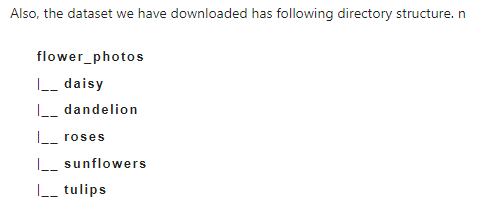

In [4]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

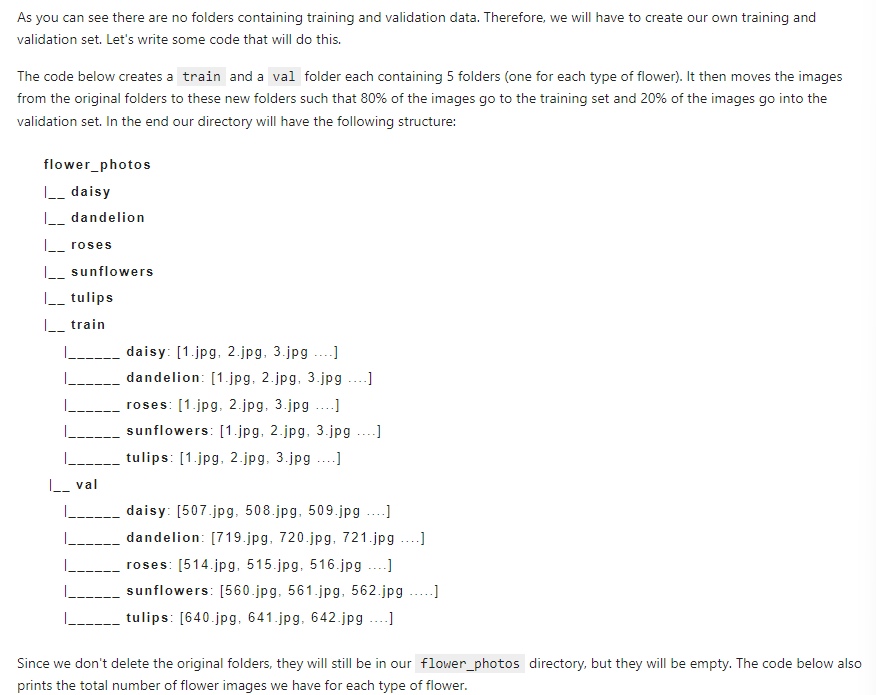

In [6]:
for cl in classes:
  img_path = os.path.join(base_dir, cl) #path to images of current class 'cl'
  images = glob.glob(img_path + '/*.jpg') #glob.glob function to find all .jpg files at img_path directory
  print("{}: {} Images".format(cl, len(images))) #prints and counts number of images
  num_train = int(round(len(images)*0.8)) #calculates number for training set (set at 80%)
  train, val = images[:num_train], images[num_train:] #Split images to train and val lists

  for t in train: #iterates over each image path in train list
    if not os.path.exists(os.path.join(base_dir, 'train', cl)): #check if 'cl' exits within train folder
      os.makedirs(os.path.join(base_dir, 'train', cl)) #creates base_dir/train/cl
    shutil.move(t, os.path.join(base_dir, 'train', cl)) #moves image file from t to desired path directory

  for v in val: #same as train above
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [8]:
#Paths for train and valdiation sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

#### Data Augmentation

In [15]:
batch_size = 100
IMG_SHAPE = 150 

##### Horizontal Flip

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


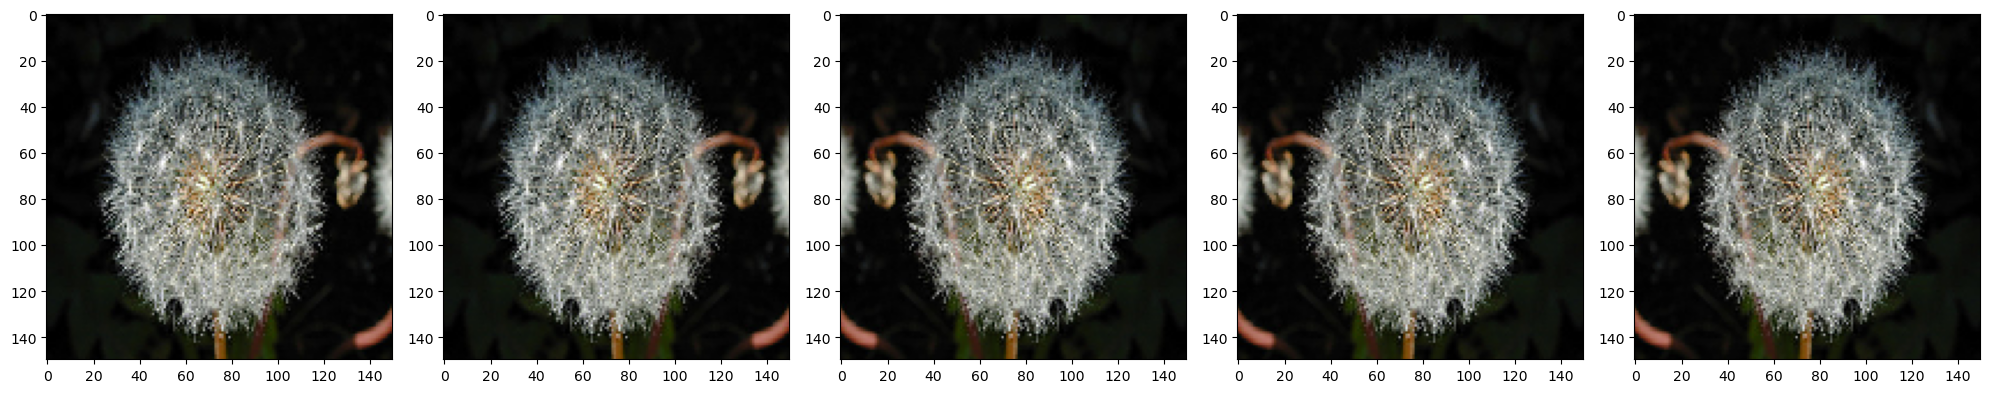

In [17]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### Random Rotation

In [18]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45) #Up to 45 degree rotation

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


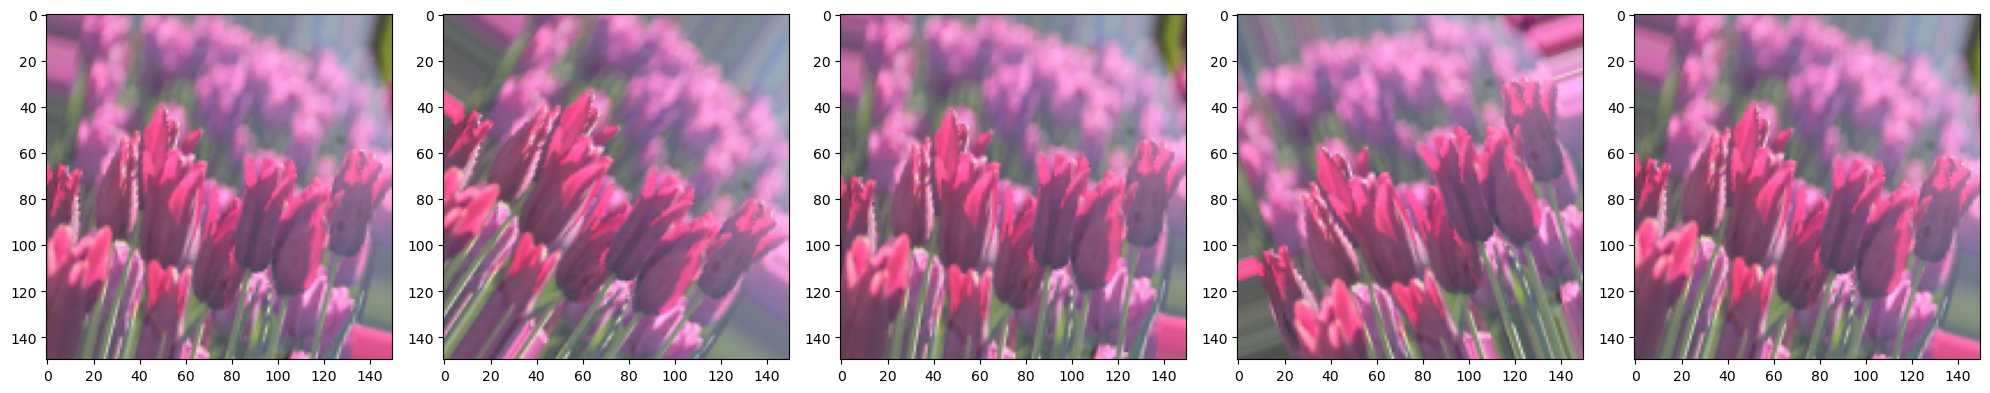

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### Random Zoom

In [22]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


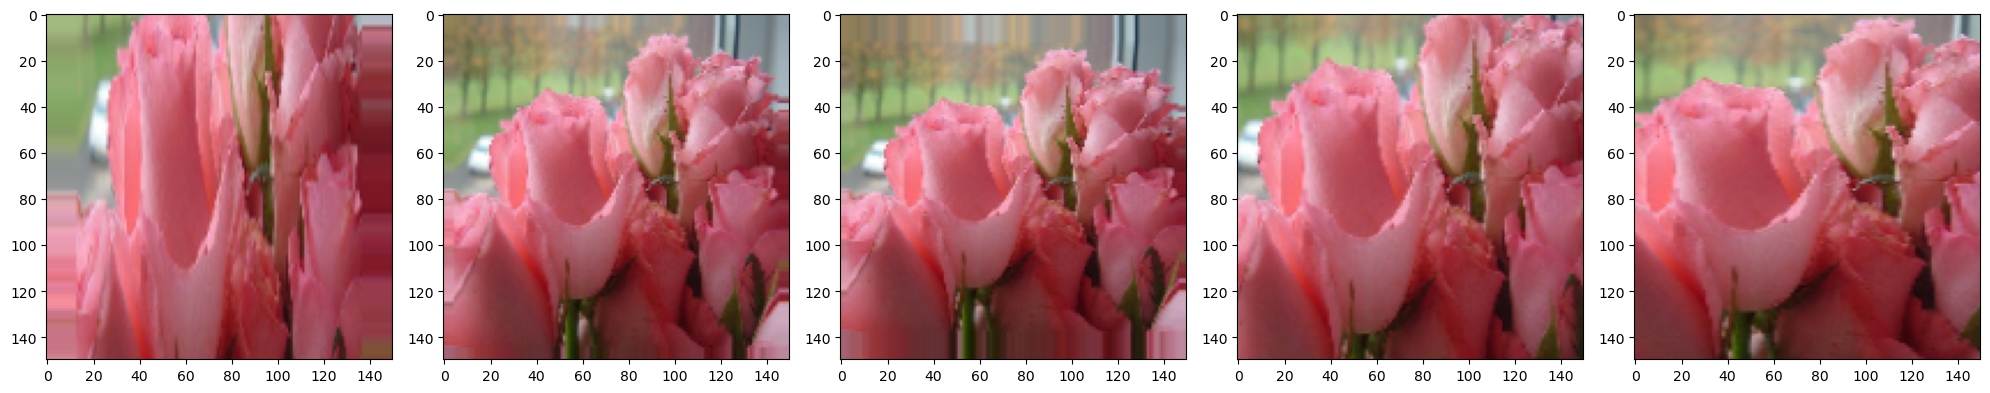

In [23]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##### Combined

In [24]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


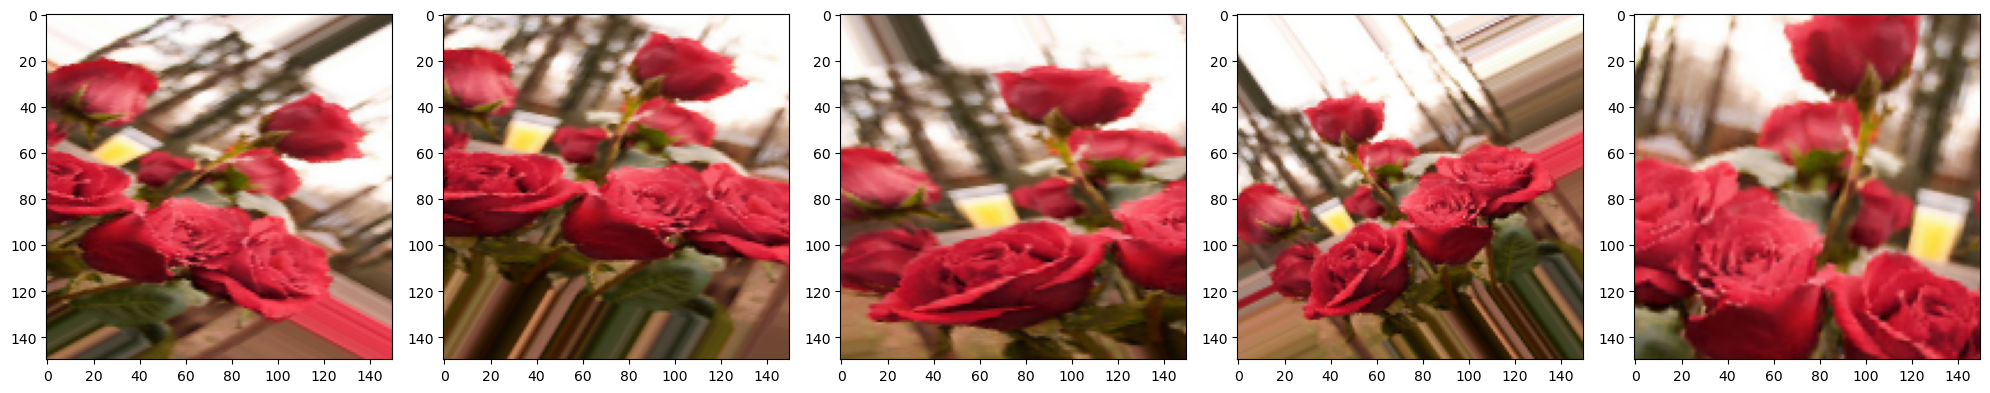

In [25]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [26]:
#Validation set, without augmentation
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


#### Convoluted Neural Network Creation

In [27]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5)) #softmax activation by default

In convolutional neural networks (CNNs), padding refers to a technique used to control the spatial dimensions (height and width) of the feature maps during convolution operations. There are three main types of padding:

1. Same Padding:

- This is the type of padding used in your code (padding='same').

- Same padding aims to maintain the original height and width of the feature map after the convolution operation.

- It achieves this by adding extra padding pixels around the borders of the input feature map. The number of padding pixels added depends on the filter size, padding type ('same' in this case), and strides used in the convolution layer.

- Here's how it works:

    - The number of padding pixels to add (both horizontally and vertically) is calculated using a formula that considers:

        - Filter size (kernel size) - denoted by F
        - Strides - denoted by S
        - Output dimension (desired to be same as input in this case) - denoted by O
        - Input dimension - denoted by I
    - The formula to calculate padding (P) is: P = ((O - 1) * S + F - I) / 2

- Benefits of same padding:

    - It simplifies reasoning about the output size of the convolution operation.
    - It allows you to focus on designing the network architecture without worrying about drastic changes in feature map sizes.

2. Valid Padding:

- Valid padding performs convolution without adding any padding pixels.
- This can result in a smaller output feature map compared to the input.
- The output size is calculated using a similar formula, but with P set to 0: O = (I - F + S) / S
- While valid padding might lead to a smaller output, it can be useful when you want to gradually decrease the spatial dimensions of the feature maps as you go deeper into the network.

3. No Padding (Zero Padding):

- This is a special case where no padding pixels are added, but the output size is still calculated assuming same padding (using the formula with P=0).
- This can lead to a smaller output size than both same padding and valid padding.
- It's generally not recommended as it can lead to information loss at the edges of the feature maps.

Choosing the Right Padding:

- Same padding is a popular choice for many CNN architectures as it maintains the spatial dimensions, making it easier to reason about output sizes.
- Valid padding can be used when you want to reduce the feature map size as you progress through the network (downsampling).
- It's important to experiment and compare the performance of your model with different padding options to see what works best for your specific task and dataset.

In your model, using padding='same' for all convolutional layers ensures that the output feature maps retain the same height and width as the input images throughout the initial convolutional stages. This can be beneficial for tasks like image classification where preserving spatial information is crucial.

#### Compile Model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train Model

In the cell below, train your model using the fit_generator function instead of the usual fit function. We have to use the fit_generator function because we are using the ImageDataGenerator class to generate batches of training and validation data for our model. Train the model for 80 epochs and make sure you use the proper parameters in the fit_generator function.

In [29]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

C:\Users\ih371\AppData\Local\Temp\ipykernel_20620\2136410573.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80


30/30 [==============================] - 25s 799ms/step - loss: 1.6226 - accuracy: 0.3073 - val_loss: 1.2511 - val_accuracy: 0.4585
Epoch 2/80
30/30 [==============================] - 14s 473ms/step - loss: 1.1928 - accuracy: 0.4876 - val_loss: 1.1464 - val_accuracy: 0.5551
Epoch 3/80
30/30 [==============================] - 14s 470ms/step - loss: 1.0721 - accuracy: 0.5652 - val_loss: 1.0310 - val_accuracy: 0.5769
Epoch 4/80
30/30 [==============================] - 14s 470ms/step - loss: 1.0081 - accuracy: 0.5843 - val_loss: 1.0336 - val_accuracy: 0.6000
Epoch 5/80
30/30 [==============================] - 14s 477ms/step - loss: 0.9679 - accuracy: 0.6020 - val_loss: 0.8841 - val_accuracy: 0.6680
Epoch 6/80
30/30 [==============================] - 15s 483ms/step - loss: 0.9112 - accuracy: 0.6351 - val_loss: 0.8875 - val_accuracy: 0.6585
Epoch 7/80
30/30 [==============================] - 14s 482ms/step - loss: 0.8809 - accuracy: 0.6501 - val_loss: 0.8407 - val_accuracy: 0.68

#### Plot Training and Validation Graphs.

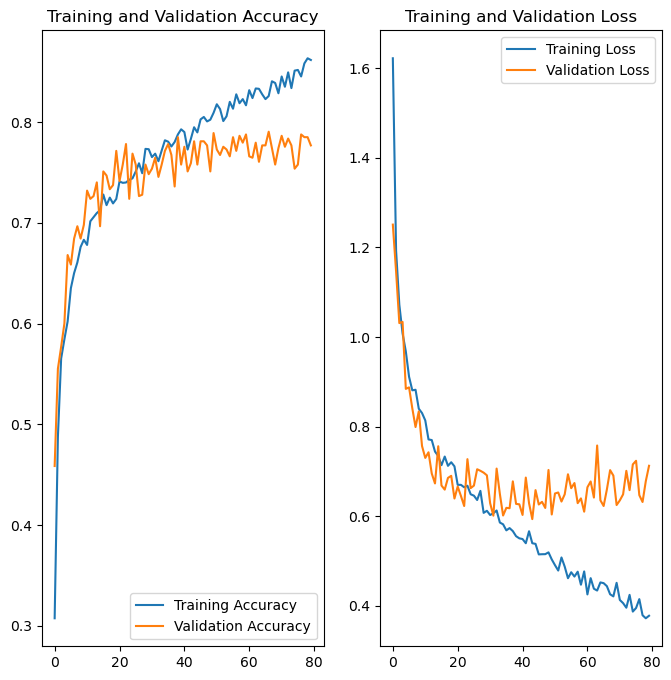

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Visualize

1/1 [==============================] - 0s 15ms/step
[-11.155102    2.0853117  -6.824054   10.023519    2.298648 ]
1/1 [==============================] - 0s 15ms/step
[ 7.7159567  -1.0607061  -0.32198635 -1.3338518  -4.480248  ]
1/1 [==============================] - 0s 15ms/step
[ -3.12227      2.5170693  -13.266835    10.272705     0.69401586]
1/1 [==============================] - 0s 16ms/step
[-11.339208    3.494689   -7.427201   15.346281   -0.9296313]
1/1 [==============================] - 0s 16ms/step
[-0.24849445 -7.758021    5.134339   -6.2907147   3.5405202 ]
1/1 [==============================] - 0s 15ms/step
[ 6.5535755 -1.6328021 -5.624666   4.367187  -3.0101178]
1/1 [==============================] - 0s 16ms/step
[-0.73557866  3.4796999  -0.16776551 -6.08698    -1.2974117 ]
1/1 [==============================] - 0s 15ms/step
[-1.5681486  -0.78736496 -8.513719    8.814901    1.5468336 ]
1/1 [==============================] - 0s 15ms/step
[-5.1060247 -6.9662566  6.913452  -8

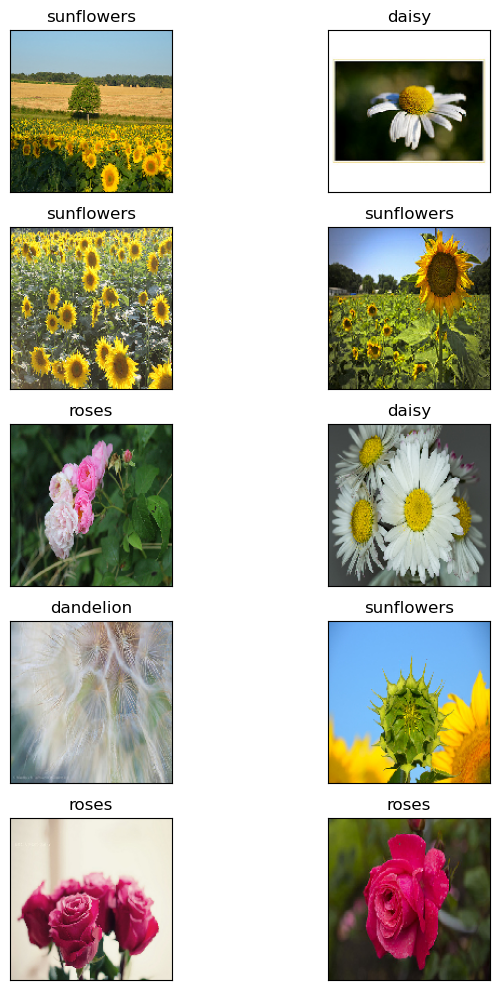

In [42]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text}")  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()